In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Step 2: Path to the ZIP file in Drive
zip_path = '/content/cropped.zip'  # Change if your ZIP is in a different folder
extract_to = '/content/cropped_extracted'  # Destination folder in Colab

# Step 3: Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ ZIP file extracted to:", extract_to)


✅ ZIP file extracted to: /content/cropped_extracted


Found 8905 images belonging to 6 classes.
Found 1068 images belonging to 6 classes.
Found 765 images belonging to 6 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2456s 9s/step - accuracy: 0.7133 - loss: 0.8294 - val_accuracy: 0.8062 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2058s 7s/step - accuracy: 0.8906 - loss: 0.3333 - val_accuracy: 0.8923 - val_loss: 0.3055 - learning_rate: 0.0010
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2019s 7s/step - accuracy: 0.9113 - loss: 0.2780 - val_accuracy: 0.9185 - val_loss: 0.2550 - learning_rate: 0.0010
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2036s 7s/step - accuracy: 0.9218 - loss: 0.2601 - val_accuracy: 0.9007 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2073s 7s/step - accuracy: 0.9261 - loss: 0.2375 - val_accuracy: 0.8792 - val_loss: 0.3817 - learning_rate: 0.0010
24/24 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.8998 - loss: 0.3382
Test Accuracy: 0.9019607901573181
24/24 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step

Classification Report:
                 precision    recall  f1-score   support

     

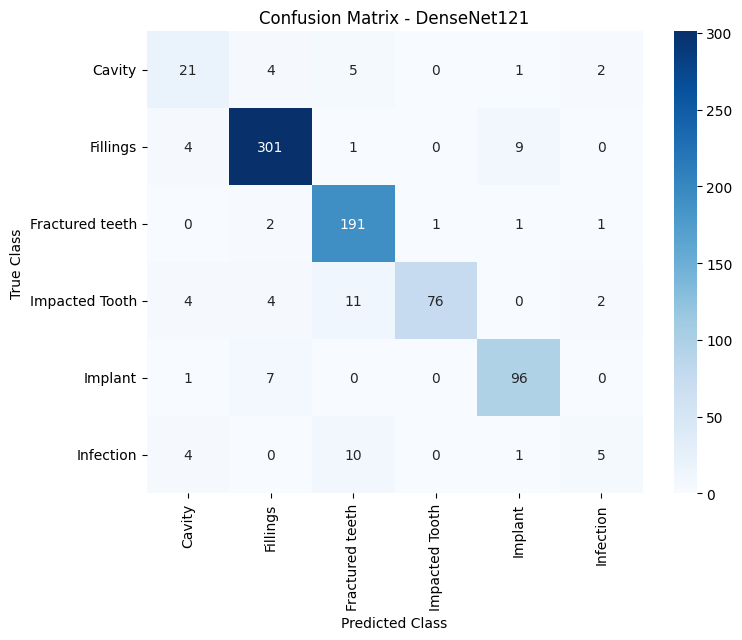

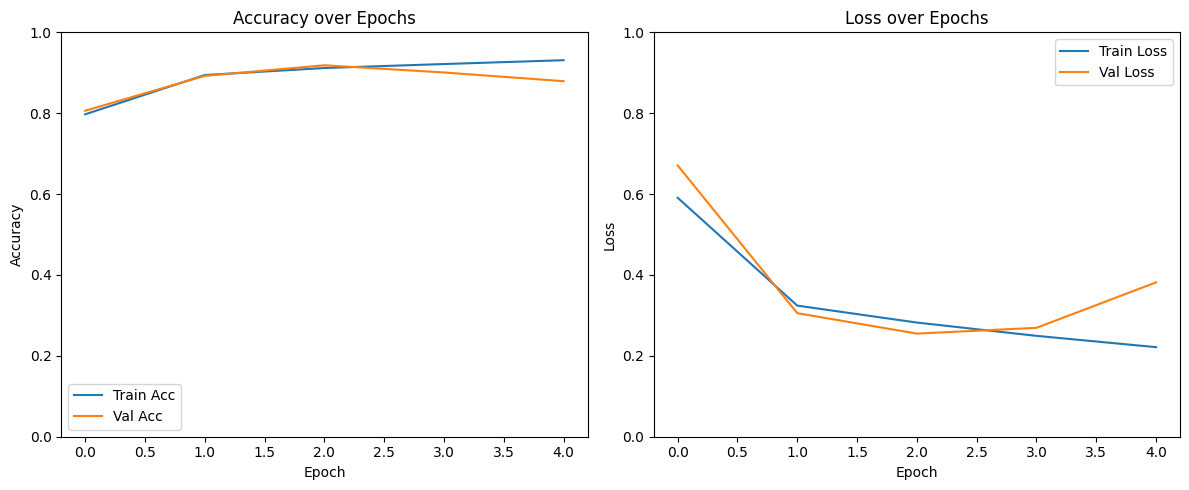

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_image
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_EPOCHS = 5

# Paths
base_dir = '/content/drive/MyDrive/my_folder'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# Data Generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    preprocessing_function=preprocess_image
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Load base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Train
history = model.fit(
    train_generator, epochs=NUM_EPOCHS,
    validation_data=valid_generator, callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

# Metrics
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - DenseNet121')
plt.show()

# Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()

# Save
model.save('dental_densenet121_model.h5')
from google.colab import files
files.download('dental_densenet121_model.h5')
